# Classification

## Import libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import auc 
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings('ignore')

In [2]:
from clickhouse_driver import Client


user_name = 'user'
pwd = 'password'

# creating connection ClickHouse
client = Client(host='clickhouse.lab.karpov.courses', port=9000,
                user=user_name, password=pwd, database='hardda')

# checking connection
result = client.execute("SELECT * FROM hardda.user_dm_events LIMIT 1")

# showing the result
for row in result[0:1]:
    print(row)

(datetime.date(2022, 2, 1), datetime.date(2022, 1, 31), 'android', 'f7411212fd0e2523e126cbfdd3f226c211212', '4beb10e1-aeeb-4c52-acd2-ce1ddbc1fc24b10e1', 22, 11, 3, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0)


## Tasks

### Task 1.

 **Write an SQL query to load the data.**

In [3]:
query = '''
SELECT 
  la.*,
  up.user_type_cars_name
FROM 
  live_adverts la
LEFT JOIN 
  user_passports up ON la.passport_id = up.passport_id
WHERE 
  execution_date BETWEEN '2022-10-01' AND '2022-11-01'
    AND region = 'Красноярск'
      AND year <> '0'
        AND created_at < '2022-10-02'
'''

In [4]:
result = client.execute(query)

In [5]:
len(result)

87286

In [6]:
df = pd.DataFrame(result, 
                  columns=['execution_date', 'advert_id', 'created_at',
                           'price', 'region', 'user_id', 'platform',
                           'auto_brand', 'auto_model', 'passport_id',
                           'year', 'user_type', 'user_type_cars_name'])

df.head()

,execution_date,advert_id,created_at,price,region,user_id,platform,auto_brand,auto_model,passport_id,year,user_type,user_type_cars_name
0,2022-10-22,139107001,2014-04-18 06:30:07,1440000,Красноярск,123550057,desktop,Nissan,Patrol,123570989,2005,0,cars_simple
1,2022-10-22,142255830,2014-10-21 17:43:15,12000000,Красноярск,123510982,unknown,Unknown,Unknown model,123531907,2012,0,cars_simple
2,2022-10-22,143662578,2015-01-09 16:47:38,12000000,Красноярск,123510982,unknown,Unknown,Unknown model,123531907,2014,0,cars_simple
3,2022-10-22,144746434,2015-02-28 23:20:10,2400000,Красноярск,123464603,desktop,Mercedes-Benz,S 350,123476026,2008,0,cars_simple
4,2022-10-22,147966866,2015-09-07 19:48:43,2000000,Красноярск,123799467,desktop,Mercedes-Benz,Vito,123820425,2011,0,cars_simple


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87286 entries, 0 to 87285
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   execution_date       87286 non-null  object        
 1   advert_id            87286 non-null  int64         
 2   created_at           87286 non-null  datetime64[ns]
 3   price                87286 non-null  int64         
 4   region               87286 non-null  object        
 5   user_id              87286 non-null  int64         
 6   platform             87286 non-null  object        
 7   auto_brand           87286 non-null  object        
 8   auto_model           87286 non-null  object        
 9   passport_id          87286 non-null  int64         
 10  year                 87286 non-null  object        
 11  user_type            87286 non-null  int64         
 12  user_type_cars_name  87286 non-null  object        
dtypes: datetime64[ns](1), int64(5),

In [8]:
df['execution_date'] = pd.to_datetime(df['execution_date'], format='%Y-%m-%d')
df['created_at'] = pd.to_datetime(df['created_at'], format='%Y-%m-%d')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87286 entries, 0 to 87285
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   execution_date       87286 non-null  datetime64[ns]
 1   advert_id            87286 non-null  int64         
 2   created_at           87286 non-null  datetime64[ns]
 3   price                87286 non-null  int64         
 4   region               87286 non-null  object        
 5   user_id              87286 non-null  int64         
 6   platform             87286 non-null  object        
 7   auto_brand           87286 non-null  object        
 8   auto_model           87286 non-null  object        
 9   passport_id          87286 non-null  int64         
 10  year                 87286 non-null  object        
 11  user_type            87286 non-null  int64         
 12  user_type_cars_name  87286 non-null  object        
dtypes: datetime64[ns](2), int64(5),

In [10]:
df = df.sort_values(['execution_date', 'user_id', 'advert_id']).reset_index(drop=True)

In [11]:
df.head()

,execution_date,advert_id,created_at,price,region,user_id,platform,auto_brand,auto_model,passport_id,year,user_type,user_type_cars_name
0,2022-10-01,265755191,2022-09-16 15:14:35,9560000,Красноярск,123457700,ios,Kia,Carnival,123464228,2022,0,cars_simple
1,2022-10-01,265927691,2022-09-20 12:20:26,1900000,Красноярск,123460471,android,Unknown,Unknown model,123467852,2003,0,cars_simple
2,2022-10-01,226358865,2020-02-22 10:30:11,2000000,Красноярск,123462064,desktop,Unknown,Unknown model,123469843,2007,0,cars_simple
3,2022-10-01,231423394,2020-07-29 09:25:16,2630000,Красноярск,123462064,desktop,Unknown,Unknown model,123469843,2007,0,cars_simple
4,2022-10-01,242062459,2021-04-14 07:17:07,1530000,Красноярск,123462064,desktop,Unknown,Unknown model,123469843,2002,0,cars_simple


Creating CHURN flags. 

In [12]:
churn_dct = {} 
ids_lst = df['passport_id'].unique().tolist()

for id_ in ids_lst:
    max_date = df[df['passport_id']== id_]['execution_date'].max()
    min_date = df[df['passport_id']== id_]['execution_date'].min()
    if (datetime(2022, 11, 1) - max_date > timedelta(days=14)) and (min_date == datetime(2022, 10, 1)):
        churn_dct[id_] = 1
    elif (max_date == datetime(2022, 11, 1)) and (min_date == datetime(2022, 10, 1)):
        churn_dct[id_] = 0
    else:
        churn_dct[id_] = 2

In [13]:
df['churn'] = df['passport_id'].map(churn_dct)

In [14]:
main_df = pd.DataFrame(list(churn_dct.items()), columns=['passport_id', 'churn'])

In [15]:
df = df[df['churn'] !=2]
main_df = main_df[main_df['churn'] !=2]

In [16]:
data = df[df['execution_date']== datetime(2022, 10, 1)].reset_index(drop=True)

In [17]:
data.head()

,execution_date,advert_id,created_at,price,region,user_id,platform,auto_brand,auto_model,passport_id,year,user_type,user_type_cars_name,churn
0,2022-10-01,265927691,2022-09-20 12:20:26,1900000,Красноярск,123460471,android,Unknown,Unknown model,123467852,2003,0,cars_simple,0
1,2022-10-01,226358865,2020-02-22 10:30:11,2000000,Красноярск,123462064,desktop,Unknown,Unknown model,123469843,2007,0,cars_simple,0
2,2022-10-01,231423394,2020-07-29 09:25:16,2630000,Красноярск,123462064,desktop,Unknown,Unknown model,123469843,2007,0,cars_simple,0
3,2022-10-01,242062459,2021-04-14 07:17:07,1530000,Красноярск,123462064,desktop,Unknown,Unknown model,123469843,2002,0,cars_simple,0
4,2022-10-01,249980206,2021-10-06 06:19:18,720000,Красноярск,123462064,desktop,Unknown,Unknown model,123469843,2008,0,cars_simple,0


### Task 2. 

**Count the number of live ads for each user on the date execution_date=='2022-10-01'. How many live ads were there in total?**

In [18]:
opening_adverts_amount_dct = {} 
ids_lst = df['passport_id'].unique().tolist()

for id_ in ids_lst:
    adv_cnt = data[data['passport_id']== id_]['advert_id'].count()
    opening_adverts_amount_dct[id_] = adv_cnt

main_df['opening_adverts_amount'] = main_df['passport_id'].map(opening_adverts_amount_dct)

In [19]:
main_df

,passport_id,churn,opening_adverts_amount
1,123467852,0,1
2,123469843,0,4
3,123475067,0,2
4,123476026,0,1
5,123478402,1,2
...,...,...,...
4463,144333254,1,1
4464,144333596,0,1
4466,144333976,1,1
4467,144334504,1,1


In [20]:
main_df['opening_adverts_amount'].sum()

4503

### Task 3.  

**Calculate their average check (average ad price per user) with prices on execution_date=='2022-10-01'. What is the largest average check found in the resulting dataset?** 

In [21]:
price_dct = {} 
ids_lst = df['passport_id'].unique().tolist()

for id_ in ids_lst:
    avg_price = data[data['passport_id']== id_]['price'].mean()
    price_dct[id_] = avg_price

main_df['price'] = main_df['passport_id'].map(price_dct)

In [22]:
main_df.price.max()

24000000.0

### Task 4. 

**Calculate the average age of cars in years. What is the median of the average car age by passport_id?** 

In [23]:
age_dct = {} 
ids_lst = df['passport_id'].unique().tolist()

data['year'] = data['year'].astype(int)
data['auto_age'] = 2022 - data['year'] 

for id_ in ids_lst:
    age = data[data['passport_id']== id_]['auto_age'].mean()
    age_dct[id_] = age

main_df['auto_age'] = main_df['passport_id'].map(age_dct)

In [24]:
main_df.auto_age.median()

14.0

### Task 5. 

**Calculate the average age of ads for a user on the date execution_date=='2022-10-01' in days. What is the largest average age of an ad found in the resulting dataset?**

In [25]:
days_dict = {} 
ids_lst = df['passport_id'].unique().tolist()

data['days_dif'] = (data['execution_date'] - data['created_at']).dt.days + 1

for id_ in ids_lst:
    days = data[data['passport_id']== id_]['days_dif'].mean()
    days_dict[id_] = days

main_df['advert_age'] = main_df['passport_id'].map(days_dict)

In [26]:
main_df['advert_age'].max()

2881.0

### Task 6. 

**Create a feature with the "most popular platform" for a user.**

In [27]:
platform_dct = {} 
ids_lst = df['passport_id'].unique().tolist()

for id_ in ids_lst:
    if len(data[data['passport_id']== id_]['platform'].value_counts()) > 1:
        if data[data['passport_id']== id_]['platform'].value_counts()[0] > data[data['passport_id']== id_]['platform'].value_counts()[1]:
            platform_dct[id_] = data[data['passport_id']== id_]['platform'].value_counts().idxmax()
        else:
            if 'android' in data[data['passport_id']== id_]['platform'].\
            value_counts()[data[data['passport_id']== id_]['platform'].value_counts()== \
                               data[data['passport_id']== id_]['platform'].value_counts()[0]].index:
                platform_dct[id_] = 'android'
            elif 'ios' in data[data['passport_id']== id_]['platform'].\
            value_counts()[data[data['passport_id']== id_]['platform'].value_counts()== \
                               data[data['passport_id']== id_]['platform'].value_counts()[0]].index:
                platform_dct[id_] = 'ios'
            elif 'desktop' in data[data['passport_id']== id_]['platform'].\
            value_counts()[data[data['passport_id']== id_]['platform'].value_counts()== \
                               data[data['passport_id']== id_]['platform'].value_counts()[0]].index:
                platform_dct[id_] = 'desktop'
            elif 'unknown' in data[data['passport_id']== id_]['platform'].\
            value_counts()[data[data['passport_id']== id_]['platform'].value_counts()== \
                               data[data['passport_id']== id_]['platform'].value_counts()[0]].index:
                platform_dct[id_] = 'unknown'
            else:
                platform_dct[id_] = 'mobile'
    else:
        platform_dct[id_] = data[data['passport_id']== id_]['platform'].value_counts().index.item()
    

main_df['platform'] = main_df['passport_id'].map(platform_dct)

In [28]:
main_df['platform'].value_counts()

android    2470
ios        1144
desktop     126
unknown       1
Name: platform, dtype: int64

### Task 7. 

**Create a feature that indicates whether a user has any ads for cars that are the most popular in terms of placement on the platform on the date execution_date=='2022-10-01'. A popular ad is considered to be the fact that the car model is included in the top 10 placed ads on the current date. How many passport_id have ads that are popular on the specified date?**

In [29]:
top_10 = data[data['auto_model'] != 'Unknown model']['auto_model'].value_counts().head(10).index

In [30]:
top_10

Index(['Camry', '2110 (седан)', '2114 (хэтчбек)', 'Passat', 'ГАЗель',
       'Granta 2190 (седан)', 'Priora 2170 (седан)', '2112 (хэтчбек)',
       '2121 Нива', 'Priora 2172 (хэтчбек)'],
      dtype='object')

In [31]:
top_10_dct = {} 
ids_lst = df['passport_id'].unique().tolist()

for id_ in ids_lst:
    models_for_id = data[data['passport_id'] == id_]['auto_model'].tolist()
    if any(model in top_10 for model in models_for_id):
        top_10_dct[id_] = 1
    else:
        top_10_dct[id_] = 0

main_df['is_top_model'] = main_df['passport_id'].map(top_10_dct)

In [32]:
main_df.is_top_model.sum()

1109

### Task 8. 

**What is the least popular user type? How many users are there?**

In [33]:
data.user_type.value_counts()

0    3992
6     286
7     117
4     108
Name: user_type, dtype: int64

In [34]:
data.user_type_cars_name.value_counts()

cars_simple    3627
cars_seller     518
                244
cars_dealer     114
Name: user_type_cars_name, dtype: int64

In [35]:
user_type_name_dct = {} 
ids_lst = df['passport_id'].unique().tolist()

for id_ in ids_lst:
    user_type_name_dct[id_] = data[data['passport_id'] == id_]['user_type_cars_name'].mode()[0]

main_df['user_type_cars_name'] = main_df['passport_id'].map(user_type_name_dct)

In [36]:
main_df.user_type_cars_name.value_counts()

cars_simple    3260
cars_seller     334
                109
cars_dealer      38
Name: user_type_cars_name, dtype: int64

### Task 9. 

**What column has missing values?**

In [37]:
main_df['user_type_cars_name'] = main_df['user_type_cars_name'].replace('', np.nan)

In [38]:
main_df['user_type_cars_name'].isna().sum()

109

### Task 10. 

**How balanced are the classes to be predicted? What minimum accuracy would we like to expect from the final model (round to hundredths)?**

In [39]:
main_df = main_df.sort_values('passport_id').reset_index(drop=True)

In [40]:
main_df

,passport_id,churn,opening_adverts_amount,price,auto_age,advert_age,platform,is_top_model,user_type_cars_name
0,123467852,0,1,1900000.0,19.0,11.00,android,0,cars_simple
1,123469843,0,4,1720000.0,16.0,660.25,desktop,0,cars_simple
2,123475067,0,2,10250000.0,7.5,632.00,android,0,cars_simple
3,123476026,0,1,2400000.0,14.0,2772.00,desktop,0,cars_simple
4,123478402,1,2,2600000.0,8.0,4.00,ios,1,cars_simple
...,...,...,...,...,...,...,...,...,...
3736,144333596,0,1,400000.0,7.0,0.00,android,0,cars_simple
3737,144333976,1,1,40000.0,19.0,0.00,ios,1,cars_simple
3738,144334504,1,1,84000.0,16.0,0.00,ios,1,cars_simple
3739,144334622,1,1,500000.0,23.0,0.00,android,0,cars_simple


In [41]:
X_ = main_df.drop(['churn', 'passport_id'], axis=1)
y_ = main_df['churn']

In [42]:
min_accuracy = sum(y_) / len(y_)
print(f'Minimal accuracy to expext: {round(min_accuracy, 2)}')

Minimal accuracy to expext: 0.78


### Task 11. 

**Prepare a validation strategy (take an ordinary KFold with parameters shuffle=True, random_state=42 and 3 folds). And then implement a basic transformer name, which:**

- Fills in the missing value with the most popular value.
- Applies OHE-encoding to categorical features.
- Does MinMax scaling.

In [43]:
splitter = KFold(
    n_splits=3,        
    shuffle=True,      
    random_state=42   
)

In [44]:
imputer_most_popular = ColumnTransformer(
    transformers=[
        ('SimpleImputer', SimpleImputer(strategy='most_frequent'), selector(dtype_exclude='number'))
    ],
    remainder='passthrough',          
    verbose_feature_names_out=False
).set_output(transform='pandas')  

In [45]:
ohe = ColumnTransformer(
    transformers=[
        ('OneHotEncoder', OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore'), selector(dtype_exclude='number'))
    ],
    remainder='passthrough',          
    verbose_feature_names_out=False
).set_output(transform='pandas')   

In [46]:
minmax_scaler = ColumnTransformer(
    transformers=[
        ('MinMaxScaler', MinMaxScaler(),selector(dtype_include='number'))
    ],
    remainder='passthrough',          
    verbose_feature_names_out=False
).set_output(transform='pandas')   

In [47]:
final_process_pipeline = Pipeline([
        ('imputer_most_popular', imputer_most_popular),
        ('ohe', ohe),
        ('minmax_scaler', minmax_scaler)
    ])

In [48]:
X_transformed = final_process_pipeline.fit_transform(X_)

In [49]:
X_transformed

,platform_desktop,platform_ios,platform_unknown,user_type_cars_name_cars_seller,user_type_cars_name_cars_simple,opening_adverts_amount,price,auto_age,advert_age,is_top_model
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.079167,0.316667,0.003818,0.0
1,1.0,0.0,0.0,0.0,1.0,0.125000,0.071667,0.266667,0.229174,0.0
2,0.0,0.0,0.0,0.0,1.0,0.041667,0.427083,0.125000,0.219368,0.0
3,1.0,0.0,0.0,0.0,1.0,0.000000,0.100000,0.233333,0.962166,0.0
4,0.0,1.0,0.0,0.0,1.0,0.041667,0.108333,0.133333,0.001388,1.0
...,...,...,...,...,...,...,...,...,...,...
3736,0.0,0.0,0.0,0.0,1.0,0.000000,0.016667,0.116667,0.000000,0.0
3737,0.0,1.0,0.0,0.0,1.0,0.000000,0.001667,0.316667,0.000000,1.0
3738,0.0,1.0,0.0,0.0,1.0,0.000000,0.003500,0.266667,0.000000,1.0
3739,0.0,0.0,0.0,0.0,1.0,0.000000,0.020833,0.383333,0.000000,0.0


In [50]:
X_transformed.to_csv('X_transformed.csv', index=False)

### Task 12. 

**Code SVMClassifier() and LogRegClassifier() classes that return predictions according to the chosen threshold. Set the random_state parameter for the models to 42.  
What are the precision, recall, and threshold of the best instance of Logistic Regression?**

In [51]:
# A helper function to print results during cross-validation
def print_dataframe(filtered_cv_results):
    """Pretty print for filtered dataframe"""
    for mean_precision, std_precision, mean_recall, std_recall, params in zip(
        filtered_cv_results['mean_test_precision'],
        filtered_cv_results['std_test_precision'],
        filtered_cv_results['mean_test_recall'],
        filtered_cv_results['std_test_recall'],
        filtered_cv_results['params'],
    ):
        print(
            f'precision: {mean_precision:0.3f} (±{std_precision:0.03f}),'
            f' recall: {mean_recall:0.3f} (±{std_recall:0.03f}),'
            f' for {params}'
        )
    print()

In [52]:
# A function to define the strategy for selecting the best hyperparameters.
def refit_strategy(cv_results):
    
    # Recall threshold 
    recall_threshold = 0.9

    # The results of all sets of hyperparameters for Precision and Recall
    cv_results_ = pd.DataFrame(cv_results)
    print('All grid-search results:')
    print_dataframe(cv_results_)

    # Removing all the models that are below our Recall Treshold
    high_recall_cv_results = cv_results_[
        cv_results_['mean_test_recall'] > recall_threshold
    ]

    print(f'Models having Recall > {recall_threshold}:')
    print_dataframe(high_recall_cv_results)

    high_recall_cv_results = high_recall_cv_results[
        [
            'mean_score_time',
            'mean_test_recall',
            'std_test_recall',
            'mean_test_precision',
            'std_test_precision',
            'rank_test_recall',
            'rank_test_precision',
            'params',
        ]
    ]

    # Choosing the best model based on the Precision metric
    best_precision = high_recall_cv_results['mean_test_precision'].max()

    high_precision_cv_results = high_recall_cv_results[
        high_recall_cv_results['mean_test_precision'] == best_precision
    ]
    print('The best model:')
    print_dataframe(high_precision_cv_results)

    # Select the index of the model that is included in high_recall_cv_results.
    # If there are more than one model in high_recall_cv_results, then select the one that runs the fastest.
    fastest_top_precision_high_recall_index = high_precision_cv_results['mean_score_time'].idxmin()

    return fastest_top_precision_high_recall_index

In [53]:
# Parameters grid for Logistic regression model and SVM model GridSearchCV
lr_grid = {
    'subestimator__simple_model__C' : [0.001, 0.01, 0.5, 1, 10, 100],  # regularization parpameter
    'subestimator__simple_model__fit_intercept': [True, False],        # fit intercept parameter
    'subestimator__simple_model__penalty': ['l1', 'l2', 'elasticnet'], # regularization type
    'subestimator__simple_model__solver': ['lbfgs', 'newton-cg'],      # optimization method
    'threshold': [0.3, 0.5, 0.7]                                       # cut-off probability threshold 
}

svm_grid = {
    'subestimator__simple_model__C' : [0.001, 0.01, 0.5, 1, 10, 100], # regularization parpameter
    'subestimator__simple_model__fit_intercept': [True, False],       # fit intercept parameter
    'subestimator__simple_model__loss': ['hinge', 'squared_hinge'],   # loss type
    'threshold': [0.3, 0.5, 0.7]                                      # cut-off probability threshold 
}

In [54]:
# pipelines for logistic regerssion and SVM models
lr_pipe = Pipeline(
    [
        ('all_preprocess', final_process_pipeline),
        ('simple_model', LogisticRegression(random_state=42))
    ]
)

svm_pipe = Pipeline(
    [
        ('all_preprocess', final_process_pipeline),
        ('simple_model', LinearSVC(random_state=42))
    ]
)

In [55]:
# Now, let's code a class for Logistic Regression with threshold as a hyperparameter.
class LogRegClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, threshold=0.5, subestimator=lr_pipe):
        self.threshold = threshold
        self.subestimator = subestimator
        
        
    def fit(self, X, y):

        # Copying data
        X, y = X.copy(), y.copy()

        # LogReg initialization
        self.subestimator.fit(X, y)

        # We have to save the targets in the class attribute, otherwise GridSearchCV will not work.
        self.classes_ = self.subestimator.classes_
        # This part will be helpful for interpretation of the model's performance
        self.coef_ = self.subestimator['simple_model'].coef_
        self.intercept_ = self.subestimator['simple_model'].intercept_
        
        self.X_ = X
        self.y_ = y
        
        return self
        
        
    def predict(self, X):
        
        # Returning predictions based on the chosen threshold value!
        probas = self.subestimator.predict_proba(X)[:, 1] > self.threshold
        
        return probas.astype(int)

    
    def predict_proba(self, X):

        return self.subestimator.predict_proba(X)
    
    
lrc_modified = LogRegClassifier(threshold = 0.5)

In [56]:
# Now, let's write a class for SVM with threshold as a hyperparameter.
class SVMClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, threshold=0.5, subestimator=svm_pipe, calibration=CalibratedClassifierCV()):
        self.threshold = threshold
        self.subestimator = subestimator
        self.calibration = calibration
        
        
    def fit(self, X, y):

        # Copying data
        X, y = X.copy(), y.copy()

        # Initializing the calibrated Estimator
        self.calibration.set_params(
            estimator=self.subestimator,
            method='isotonic',
            cv=3
        )
        self.calibration.fit(X, y)

        self.classes_ = self.calibration.classes_
        self.X_ = X
        self.y_ = y
        
        return self
        
        
    def predict(self, X):
        
        # Returning predictions based on the chosen threshold value!
        probas = self.calibration.predict_proba(X)[:, 1] > self.threshold
        
        return probas.astype(int)

    
    def predict_proba(self, X):

        return self.calibration.predict_proba(X)
    
    
svmc_modified = SVMClassifier(threshold = 0.7)

In [57]:
# Let's find the best set of parameters for Logistic Regression model
scores = ('precision', 'recall')

print('Looking for the best set of parameters for Logistic Regression model:')
search_lr = GridSearchCV(lrc_modified, lr_grid, 
                         cv=splitter, scoring=scores,
                         refit=refit_strategy)

search_lr.fit(X_transformed, y_) 

Looking for the best set of parameters for Logistic Regression model:
All grid-search results:
precision: nan (±nan), recall: nan (±nan), for {'subestimator__simple_model__C': 0.001, 'subestimator__simple_model__fit_intercept': True, 'subestimator__simple_model__penalty': 'l1', 'subestimator__simple_model__solver': 'lbfgs', 'threshold': 0.3}
precision: nan (±nan), recall: nan (±nan), for {'subestimator__simple_model__C': 0.001, 'subestimator__simple_model__fit_intercept': True, 'subestimator__simple_model__penalty': 'l1', 'subestimator__simple_model__solver': 'lbfgs', 'threshold': 0.5}
precision: nan (±nan), recall: nan (±nan), for {'subestimator__simple_model__C': 0.001, 'subestimator__simple_model__fit_intercept': True, 'subestimator__simple_model__penalty': 'l1', 'subestimator__simple_model__solver': 'lbfgs', 'threshold': 0.7}
precision: nan (±nan), recall: nan (±nan), for {'subestimator__simple_model__C': 0.001, 'subestimator__simple_model__fit_intercept': True, 'subestimator__simp

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=LogRegClassifier(),
             param_grid={'subestimator__simple_model__C': [0.001, 0.01, 0.5, 1,
                                                           10, 100],
                         'subestimator__simple_model__fit_intercept': [True,
                                                                       False],
                         'subestimator__simple_model__penalty': ['l1', 'l2',
                                                                 'elasticnet'],
                         'subestimator__simple_model__solver': ['lbfgs',
                                                                'newton-cg'],
                         'threshold': [0.3, 0.5, 0.7]},
             refit=<function refit_strategy at 0x7fce1faeb5e0>,
             scoring=('precision', 'recall'))

### Task 13. 

**What are the precision, recall, and threshold of the best instance of SVM?**

In [58]:
# Let's find the best set of parameters for SVM model
scores = ('precision', 'recall')

print('Looking for the best set of parameters for SVM model:')
search_svm = GridSearchCV(svmc_modified, svm_grid, 
                          cv=splitter, scoring=scores,
                          refit=refit_strategy)

search_svm.fit(X_transformed, y_) 

Looking for the best set of parameters for SVM model:
All grid-search results:
precision: 0.778 (±0.003), recall: 1.000 (±0.000), for {'subestimator__simple_model__C': 0.001, 'subestimator__simple_model__fit_intercept': True, 'subestimator__simple_model__loss': 'hinge', 'threshold': 0.3}
precision: 0.779 (±0.003), recall: 0.996 (±0.005), for {'subestimator__simple_model__C': 0.001, 'subestimator__simple_model__fit_intercept': True, 'subestimator__simple_model__loss': 'hinge', 'threshold': 0.5}
precision: 0.798 (±0.010), recall: 0.875 (±0.048), for {'subestimator__simple_model__C': 0.001, 'subestimator__simple_model__fit_intercept': True, 'subestimator__simple_model__loss': 'hinge', 'threshold': 0.7}
precision: 0.778 (±0.003), recall: 0.999 (±0.001), for {'subestimator__simple_model__C': 0.001, 'subestimator__simple_model__fit_intercept': True, 'subestimator__simple_model__loss': 'squared_hinge', 'threshold': 0.3}
precision: 0.780 (±0.004), recall: 0.991 (±0.007), for {'subestimator__si

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=SVMClassifier(threshold=0.7),
             param_grid={'subestimator__simple_model__C': [0.001, 0.01, 0.5, 1,
                                                           10, 100],
                         'subestimator__simple_model__fit_intercept': [True,
                                                                       False],
                         'subestimator__simple_model__loss': ['hinge',
                                                              'squared_hinge'],
                         'threshold': [0.3, 0.5, 0.7]},
             refit=<function refit_strategy at 0x7fce1faeb5e0>,
             scoring=('precision', 'recall'))

SVM is better because it has a better Precision having the same level of Recall. 

### Task 14.

**Let's add information about customer transactional activity to the dataset.**

In [59]:
query = '''
SELECT  
  passport_id, 
  type, 
  amount
FROM 
  user_transactions
WHERE 
  payment_date::date BETWEEN '2022-09-01' AND '2022-10-01'
'''

In [60]:
result = client.execute(query)

In [61]:
len(result)

1510628

In [62]:
df_transactions = pd.DataFrame(result, 
                  columns=['passport_id', 'transaction_type', 'amount'])

df_transactions.head()

,passport_id,transaction_type,amount
0,126395321,automatic renewal,0
1,124538666,automatic renewal,0
2,134904399,automatic renewal,0
3,126395321,automatic renewal,0
4,143073072,automatic renewal,0


In [63]:
df_transactions['category'] = df_transactions['transaction_type'].apply(lambda x: 'revenue' if x in ('basic sale', 'fast sale', 'quick sale') 
                                                            else ('renewal' if x in ('renewal', 'archived renewal', 'automatic renewal') 
                                                                else ('premium' if x in ('premium', 'premium weekly') 
                                                                    else 'other')))
 

In [64]:
df_transactions.head()

,passport_id,transaction_type,amount,category
0,126395321,automatic renewal,0,renewal
1,124538666,automatic renewal,0,renewal
2,134904399,automatic renewal,0,renewal
3,126395321,automatic renewal,0,renewal
4,143073072,automatic renewal,0,renewal


In [65]:
df_transactions.category.value_counts()

other      1025687
renewal     306841
revenue     126587
premium      51513
Name: category, dtype: int64

In [66]:
df_transactions.passport_id.nunique()

296392

In [67]:
transactions_pivot = df_transactions.pivot_table(index='passport_id', columns='category', values='amount',
                            aggfunc='sum',fill_value=0).reset_index()

In [68]:
transactions_pivot

category,passport_id,other,premium,renewal,revenue
0,123463039,0,0,-235,0
1,123463044,-400,0,-1320,-3666
2,123463046,-2830,-1770,-2890,-18926
3,123463060,0,0,-490,0
4,123463086,0,0,0,-500
...,...,...,...,...,...
296387,144335018,0,0,0,0
296388,144335050,0,0,0,0
296389,144335082,0,0,0,0
296390,144335084,0,0,0,0


In [69]:
all_df = pd.merge(main_df, transactions_pivot[['passport_id', 'premium', 'renewal', 'revenue']],
                  how='left', on='passport_id')

In [70]:
all_df

,passport_id,churn,opening_adverts_amount,price,auto_age,advert_age,platform,is_top_model,user_type_cars_name,premium,renewal,revenue
0,123467852,0,1,1900000.0,19.0,11.00,android,0,cars_simple,NaN,NaN,NaN
1,123469843,0,4,1720000.0,16.0,660.25,desktop,0,cars_simple,NaN,NaN,NaN
2,123475067,0,2,10250000.0,7.5,632.00,android,0,cars_simple,NaN,NaN,NaN
3,123476026,0,1,2400000.0,14.0,2772.00,desktop,0,cars_simple,0.0,-760.0,0.0
4,123478402,1,2,2600000.0,8.0,4.00,ios,1,cars_simple,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3736,144333596,0,1,400000.0,7.0,0.00,android,0,cars_simple,0.0,0.0,0.0
3737,144333976,1,1,40000.0,19.0,0.00,ios,1,cars_simple,0.0,0.0,0.0
3738,144334504,1,1,84000.0,16.0,0.00,ios,1,cars_simple,0.0,0.0,0.0
3739,144334622,1,1,500000.0,23.0,0.00,android,0,cars_simple,0.0,0.0,0.0


In [71]:
all_df.passport_id.nunique()

3741

In [72]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3741 entries, 0 to 3740
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   passport_id             3741 non-null   int64  
 1   churn                   3741 non-null   int64  
 2   opening_adverts_amount  3741 non-null   int64  
 3   price                   3741 non-null   float64
 4   auto_age                3741 non-null   float64
 5   advert_age              3741 non-null   float64
 6   platform                3741 non-null   object 
 7   is_top_model            3741 non-null   int64  
 8   user_type_cars_name     3632 non-null   object 
 9   premium                 3298 non-null   float64
 10  renewal                 3298 non-null   float64
 11  revenue                 3298 non-null   float64
dtypes: float64(6), int64(4), object(2)
memory usage: 379.9+ KB


In [73]:
all_df.fillna({'premium': 0, 'renewal': 0, 'revenue':0}, inplace=True)

In [74]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3741 entries, 0 to 3740
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   passport_id             3741 non-null   int64  
 1   churn                   3741 non-null   int64  
 2   opening_adverts_amount  3741 non-null   int64  
 3   price                   3741 non-null   float64
 4   auto_age                3741 non-null   float64
 5   advert_age              3741 non-null   float64
 6   platform                3741 non-null   object 
 7   is_top_model            3741 non-null   int64  
 8   user_type_cars_name     3632 non-null   object 
 9   premium                 3741 non-null   float64
 10  renewal                 3741 non-null   float64
 11  revenue                 3741 non-null   float64
dtypes: float64(6), int64(4), object(2)
memory usage: 379.9+ KB


In [75]:
all_df.premium.mean()

-69.78348035284684

In [76]:
all_df.renewal.mean()

-667.4632451216253

In [77]:
all_df.revenue.mean()

-613.1903234429298

### Task 15. 

**Let's repeat the experiment with the models and see if we can beat the previous result. What are the precision, recall, and threshold of the best instance of Logistic Regression?**

In [78]:
X_ = all_df.drop(['churn', 'passport_id'], axis=1)
y_ = all_df['churn']

X_transformed = final_process_pipeline.fit_transform(X_)

In [79]:
# Let's find the best set of parameters for Logistic Regression model
scores = ('precision', 'recall')

print('Looking for the best set of parameters for Logistic Regression model:')
search_lr = GridSearchCV(lrc_modified, lr_grid, 
                         cv=splitter, scoring=scores,
                         refit=refit_strategy)

search_lr.fit(X_transformed, y_) 

Looking for the best set of parameters for Logistic Regression model:
All grid-search results:
precision: nan (±nan), recall: nan (±nan), for {'subestimator__simple_model__C': 0.001, 'subestimator__simple_model__fit_intercept': True, 'subestimator__simple_model__penalty': 'l1', 'subestimator__simple_model__solver': 'lbfgs', 'threshold': 0.3}
precision: nan (±nan), recall: nan (±nan), for {'subestimator__simple_model__C': 0.001, 'subestimator__simple_model__fit_intercept': True, 'subestimator__simple_model__penalty': 'l1', 'subestimator__simple_model__solver': 'lbfgs', 'threshold': 0.5}
precision: nan (±nan), recall: nan (±nan), for {'subestimator__simple_model__C': 0.001, 'subestimator__simple_model__fit_intercept': True, 'subestimator__simple_model__penalty': 'l1', 'subestimator__simple_model__solver': 'lbfgs', 'threshold': 0.7}
precision: nan (±nan), recall: nan (±nan), for {'subestimator__simple_model__C': 0.001, 'subestimator__simple_model__fit_intercept': True, 'subestimator__simp

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=LogRegClassifier(),
             param_grid={'subestimator__simple_model__C': [0.001, 0.01, 0.5, 1,
                                                           10, 100],
                         'subestimator__simple_model__fit_intercept': [True,
                                                                       False],
                         'subestimator__simple_model__penalty': ['l1', 'l2',
                                                                 'elasticnet'],
                         'subestimator__simple_model__solver': ['lbfgs',
                                                                'newton-cg'],
                         'threshold': [0.3, 0.5, 0.7]},
             refit=<function refit_strategy at 0x7fce1faeb5e0>,
             scoring=('precision', 'recall'))

### Task 16. 

**What are the precision, recall, and threshold of the best instance of SVM model?**

In [80]:
# Let's find the best set of parameters for SVM model
scores = ('precision', 'recall')

print('Looking for the best set of parameters for SVM model:')
search_svm = GridSearchCV(svmc_modified, svm_grid, 
                          cv=splitter, scoring=scores,
                          refit=refit_strategy)

search_svm.fit(X_transformed, y_) 

Looking for the best set of parameters for SVM model:
All grid-search results:
precision: 0.779 (±0.005), recall: 1.000 (±0.000), for {'subestimator__simple_model__C': 0.001, 'subestimator__simple_model__fit_intercept': True, 'subestimator__simple_model__loss': 'hinge', 'threshold': 0.3}
precision: 0.780 (±0.005), recall: 0.996 (±0.002), for {'subestimator__simple_model__C': 0.001, 'subestimator__simple_model__fit_intercept': True, 'subestimator__simple_model__loss': 'hinge', 'threshold': 0.5}
precision: 0.828 (±0.015), recall: 0.813 (±0.033), for {'subestimator__simple_model__C': 0.001, 'subestimator__simple_model__fit_intercept': True, 'subestimator__simple_model__loss': 'hinge', 'threshold': 0.7}
precision: 0.779 (±0.005), recall: 0.998 (±0.001), for {'subestimator__simple_model__C': 0.001, 'subestimator__simple_model__fit_intercept': True, 'subestimator__simple_model__loss': 'squared_hinge', 'threshold': 0.3}
precision: 0.784 (±0.003), recall: 0.993 (±0.001), for {'subestimator__si

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=SVMClassifier(threshold=0.7),
             param_grid={'subestimator__simple_model__C': [0.001, 0.01, 0.5, 1,
                                                           10, 100],
                         'subestimator__simple_model__fit_intercept': [True,
                                                                       False],
                         'subestimator__simple_model__loss': ['hinge',
                                                              'squared_hinge'],
                         'threshold': [0.3, 0.5, 0.7]},
             refit=<function refit_strategy at 0x7fce1faeb5e0>,
             scoring=('precision', 'recall'))

### Task 17. 

**Among all the models that were obtained today, choose the best one by precision and calculate its PR-AUC, ROC-AUC, and F-measure.**

In [81]:
X_ = main_df.drop(['churn', 'passport_id'], axis=1)
y_ = main_df['churn']

X_transformed = final_process_pipeline.fit_transform(X_)

In [82]:
# The best model
scores = ('precision', 'recall')

print('Looking for the best set of parameters for SVM model:')
search_svm = GridSearchCV(svmc_modified, svm_grid, 
                          cv=splitter, scoring=scores,
                          refit=refit_strategy)

search_svm.fit(X_transformed, y_) 

Looking for the best set of parameters for SVM model:
All grid-search results:
precision: 0.778 (±0.003), recall: 1.000 (±0.000), for {'subestimator__simple_model__C': 0.001, 'subestimator__simple_model__fit_intercept': True, 'subestimator__simple_model__loss': 'hinge', 'threshold': 0.3}
precision: 0.779 (±0.003), recall: 0.996 (±0.005), for {'subestimator__simple_model__C': 0.001, 'subestimator__simple_model__fit_intercept': True, 'subestimator__simple_model__loss': 'hinge', 'threshold': 0.5}
precision: 0.798 (±0.010), recall: 0.875 (±0.048), for {'subestimator__simple_model__C': 0.001, 'subestimator__simple_model__fit_intercept': True, 'subestimator__simple_model__loss': 'hinge', 'threshold': 0.7}
precision: 0.778 (±0.003), recall: 0.999 (±0.001), for {'subestimator__simple_model__C': 0.001, 'subestimator__simple_model__fit_intercept': True, 'subestimator__simple_model__loss': 'squared_hinge', 'threshold': 0.3}
precision: 0.780 (±0.004), recall: 0.991 (±0.007), for {'subestimator__si

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=SVMClassifier(threshold=0.7),
             param_grid={'subestimator__simple_model__C': [0.001, 0.01, 0.5, 1,
                                                           10, 100],
                         'subestimator__simple_model__fit_intercept': [True,
                                                                       False],
                         'subestimator__simple_model__loss': ['hinge',
                                                              'squared_hinge'],
                         'threshold': [0.3, 0.5, 0.7]},
             refit=<function refit_strategy at 0x7fce1faeb5e0>,
             scoring=('precision', 'recall'))

In [83]:
# Calculating F1-score
print(f'F1-score: {f1_score(y_, search_svm.predict(X_transformed)):.3f}' )

F1-score: 0.874


In [84]:
# Calculating Roc-AUC
fpr, tpr, thresholds = roc_curve(y_, search_svm.predict_proba(X_transformed)[:, 1])
print(auc(fpr, tpr))

0.813679323173561


In [85]:
# Calculating PR-AUC
precision, recall, thresholds = precision_recall_curve(y_,search_svm.predict_proba(X_transformed)[:, 1])
print(auc(recall, precision))

0.93127583993947


### Task 18. 

**Calculate the permutation importance for features in the final model. Which feature is the most significant?**

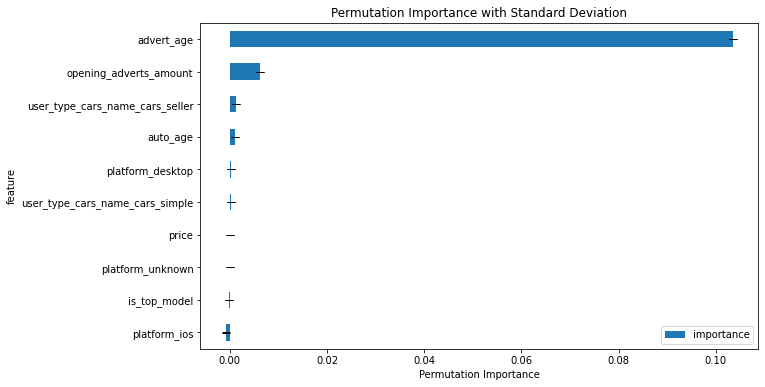

In [86]:
result = permutation_importance(search_svm.best_estimator_, 
                                X_transformed, y_, n_repeats=10, random_state=42)


feature_importance = pd.DataFrame({'feature': X_transformed.columns,
                                   'importance': result.importances_mean,
                                   'std': result.importances_std})

feature_importance = feature_importance.sort_values('importance', ascending=True)


ax = feature_importance.plot(x='feature', y='importance', 
                             kind='barh', figsize=(10, 6), yerr='std', capsize=4)

ax.set_xlabel('Permutation Importance')
ax.set_title('Permutation Importance with Standard Deviation');